# Phase 1: Unconditional Flow Matching

In this notebook, we'll learn how **flow matching** works by building a generative model for MNIST digits.

## What is Flow Matching?

Flow matching is a technique for training generative models. The key idea:

1. **Define straight paths** from data points to noise
2. **Learn the velocity field** that describes these paths
3. **Generate samples** by starting from noise and following the velocity backward

### The Math (Simplified)

Given:
- $x_0$ = clean image (data)
- $x_1$ = pure noise ~ $\mathcal{N}(0, I)$
- $t$ = timestep in [0, 1]

**Forward process** (interpolation):
$$x_t = (1 - t) \cdot x_0 + t \cdot x_1$$

**Velocity** (what we train the model to predict):
$$v = \frac{dx_t}{dt} = x_1 - x_0$$

This creates straight-line paths from data to noise. The model learns to reverse this.

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Set up device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## 1. Load MNIST Dataset

We'll use MNIST (28x28 grayscale digits) as our training data. It's simple enough to train quickly but complex enough to see interesting results.

In [8]:
# Transform: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Maps [0,1] to [-1,1]
])

# Download and load MNIST
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,  # Set to 0 for MPS compatibility
    drop_last=True
)

print(f"Dataset size: {len(train_dataset):,} images")
print(f"Batches per epoch: {len(train_loader)}")

Dataset size: 60,000 images
Batches per epoch: 468


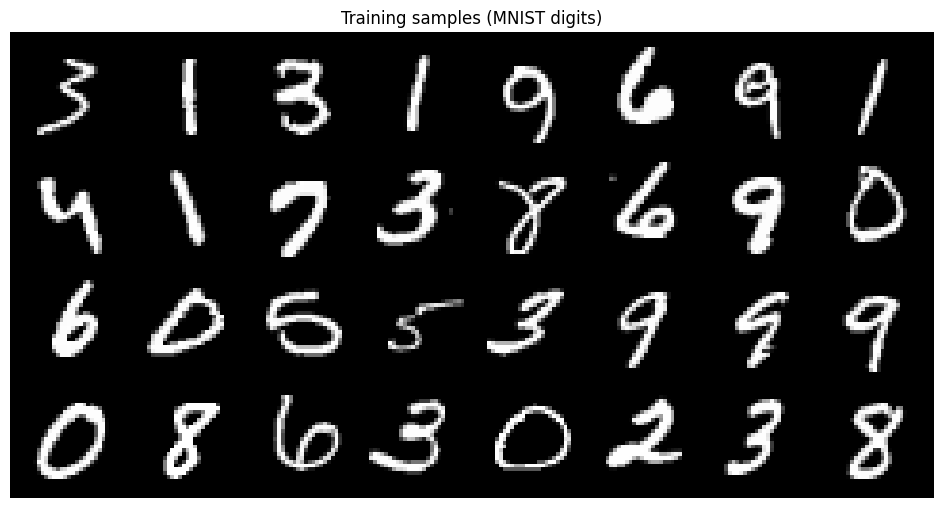

In [9]:
# Visualize some training samples
def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    # Denormalize from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    images = images.clamp(0, 1)
    
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Get a batch and visualize
sample_batch, _ = next(iter(train_loader))
show_images(sample_batch[:32], title="Training samples (MNIST digits)")

## 2. Visualize the Forward Process

Let's see what the interpolation from data to noise looks like. This is the path our model will learn to reverse.

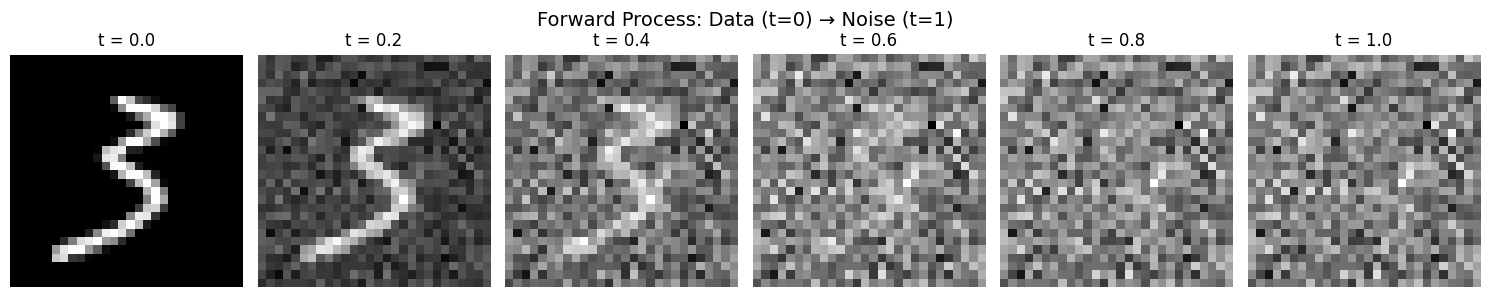

In [10]:
from opticus.flow import FlowMatching

flow = FlowMatching()

# Take one image and show its path to noise
x_0 = sample_batch[0:1]  # Shape: (1, 1, 28, 28)
x_1 = torch.randn_like(x_0)  # Sample noise

# Show interpolation at different timesteps
timesteps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
interpolated = []

for t in timesteps:
    t_tensor = torch.tensor([t])
    x_t, _ = flow.forward_process(x_0, x_1, t_tensor)
    interpolated.append(x_t)

# Visualize
fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))
for i, (ax, t) in enumerate(zip(axes, timesteps)):
    img = (interpolated[i][0, 0] + 1) / 2  # Denormalize
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title(f't = {t}')
    ax.axis('off')
plt.suptitle('Forward Process: Data (t=0) → Noise (t=1)', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Create the Model

We use a simple U-Net style CNN that takes:
- `x_t`: The noised image at timestep t
- `t`: The timestep value (encoded with sinusoidal embeddings)

And outputs the predicted velocity field `v`.

In [11]:
from opticus.models import SimpleUNet

model = SimpleUNet(
    in_channels=1,       # Grayscale images
    model_channels=64,   # Base channel count
    time_emb_dim=128,    # Timestep embedding dimension
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

# Test forward pass
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)
test_out = model(test_x, test_t)
print(f"Input shape: {test_x.shape}")
print(f"Output shape: {test_out.shape}")

Model parameters: 1,837,185
Input shape: torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 1, 28, 28])


## 4. Training

The training loop:
1. Sample a batch of images $x_0$
2. Sample noise $x_1 \sim \mathcal{N}(0, I)$
3. Sample random timesteps $t \sim U[0, 1]$
4. Compute interpolated samples $x_t$
5. Predict velocity $\hat{v} = \text{model}(x_t, t)$
6. Loss = MSE between $\hat{v}$ and true velocity $v = x_1 - x_0$

In [12]:
from opticus.train import Trainer

# Create trainer
trainer = Trainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    device=device,
)

# Train for a few epochs (increase for better results)
NUM_EPOCHS = 30  # Start with 10, increase to 30-50 for better quality

losses = trainer.train(num_epochs=NUM_EPOCHS)

Training on cuda
Model parameters: 1,837,185


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.59it/s, loss=0.2394]


Epoch 1: avg_loss = 0.3529


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.55it/s, loss=0.2172]


Epoch 2: avg_loss = 0.2319


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s, loss=0.2089]


Epoch 3: avg_loss = 0.2161


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.56it/s, loss=0.1917]


Epoch 4: avg_loss = 0.2056


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.56it/s, loss=0.1881]


Epoch 5: avg_loss = 0.2005


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s, loss=0.1913]


Epoch 6: avg_loss = 0.1958


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s, loss=0.2066]


Epoch 7: avg_loss = 0.1928


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.44it/s, loss=0.1867]


Epoch 8: avg_loss = 0.1898


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.2026]


Epoch 9: avg_loss = 0.1881


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.51it/s, loss=0.1979]


Epoch 10: avg_loss = 0.1868


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s, loss=0.1884]


Epoch 11: avg_loss = 0.1856


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.30it/s, loss=0.1806]


Epoch 12: avg_loss = 0.1842


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.35it/s, loss=0.1943]


Epoch 13: avg_loss = 0.1829


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.51it/s, loss=0.1775]


Epoch 14: avg_loss = 0.1822


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.46it/s, loss=0.1784]


Epoch 15: avg_loss = 0.1804


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.45it/s, loss=0.1903]


Epoch 16: avg_loss = 0.1805


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.49it/s, loss=0.1901]


Epoch 17: avg_loss = 0.1788


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1914]


Epoch 18: avg_loss = 0.1788


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s, loss=0.1791]


Epoch 19: avg_loss = 0.1787


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.46it/s, loss=0.1728]


Epoch 20: avg_loss = 0.1770


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s, loss=0.1789]


Epoch 21: avg_loss = 0.1774


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1623]


Epoch 22: avg_loss = 0.1773


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s, loss=0.1762]


Epoch 23: avg_loss = 0.1759


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s, loss=0.1784]


Epoch 24: avg_loss = 0.1756


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s, loss=0.1674]


Epoch 25: avg_loss = 0.1759


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s, loss=0.1761]


Epoch 26: avg_loss = 0.1751


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.49it/s, loss=0.1692]


Epoch 27: avg_loss = 0.1744


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.55it/s, loss=0.1671]


Epoch 28: avg_loss = 0.1746


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.56it/s, loss=0.1693]


Epoch 29: avg_loss = 0.1745


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1809]

Epoch 30: avg_loss = 0.1738


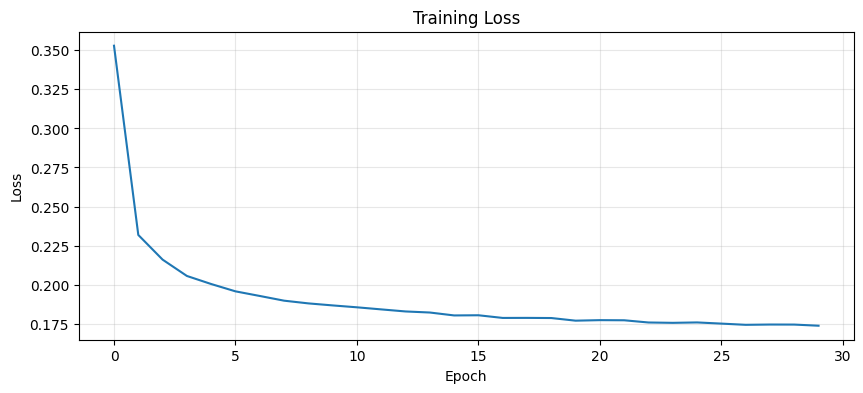

In [13]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Generate Samples!

Now the exciting part - generating new digits from pure noise.

The sampling process:
1. Start with pure noise at $t=1$
2. Use the model to predict velocity at each step
3. Take small steps backward in time: $x_{t-dt} = x_t - dt \cdot v(x_t, t)$
4. End up at $t=0$ with a generated image

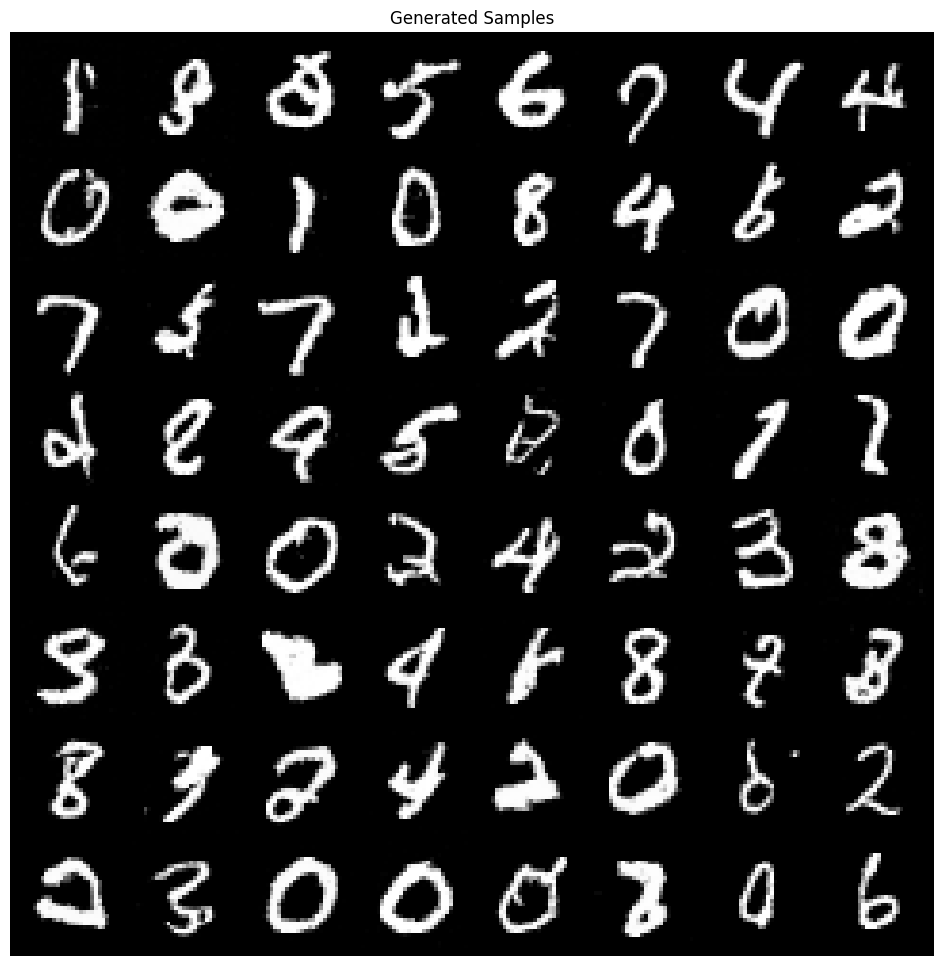

In [14]:
from opticus.sampling import sample

# Generate samples
model.eval()
with torch.no_grad():
    generated, trajectory = sample(
        model=model,
        num_samples=64,
        image_shape=(1, 28, 28),
        num_steps=50,
        device=device,
        return_trajectory=True,
    )

show_images(generated, nrow=8, title="Generated Samples")

## 6. Visualize the Generation Process

Let's see how the model transforms noise into digits step by step.

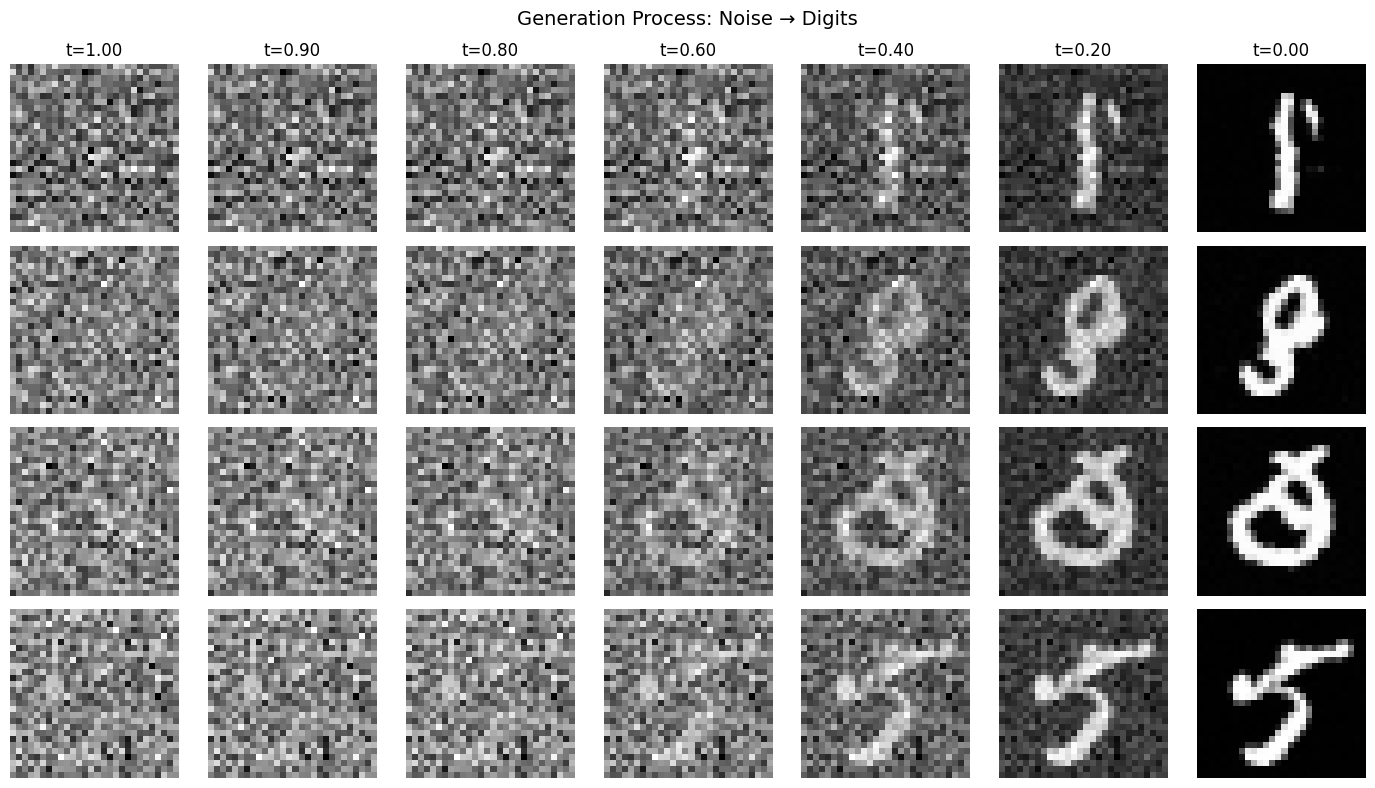

In [15]:
# Show the trajectory for a few samples
num_to_show = 4
steps_to_show = [0, 5, 10, 20, 30, 40, 50]  # Which steps to visualize

fig, axes = plt.subplots(num_to_show, len(steps_to_show), figsize=(14, 8))

for row in range(num_to_show):
    for col, step_idx in enumerate(steps_to_show):
        img = trajectory[step_idx][row, 0]
        img = (img + 1) / 2  # Denormalize
        axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
        axes[row, col].axis('off')
        if row == 0:
            t_val = 1.0 - step_idx / 50
            axes[row, col].set_title(f't={t_val:.2f}')

plt.suptitle('Generation Process: Noise → Digits', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Save the Model (Optional)

Save the trained model for later use.

In [16]:
# Save the trained model for use in Phase 2
trainer.save_checkpoint("phase1_model.pt")
print("Model saved to phase1_model.pt")

Model saved to phase1_model.pt


## Key Takeaways

1. **Flow matching creates straight paths** from data to noise via linear interpolation

2. **The velocity field is constant** along each path: $v = x_1 - x_0$

3. **Training is simple**: just MSE loss between predicted and true velocity

4. **Sampling reverses the process**: start from noise, follow velocity field backward

5. **This is unconditional**: we generate random digits with no control over which digit

## Next Steps (Phase 2)

In Phase 2, we'll replace the simple CNN with a **Diffusion Transformer (DiT)**:
- Patchify images into sequences
- Use transformer blocks instead of convolutions
- Adaptive layer norm (adaLN) for timestep conditioning

This will give us sharper results and prepare us for text conditioning.